# Introduction

The goal of this project is to predict which game users that are likely to spend money after finishing a game's tutorial. If such users can be identified based on their early behavior (before they spend anything), they can be offered different pricing to try and improve overall profits.

The data provided contains a column 'total_spend' indicating the amount of money the player has spent in the game to date (assumed). For all other columns, it is assumed that the data would be available for a new user on which we would like to run the prediction algorithm.

In the following workflow, a logistic regression model is developed which classifies users based on whether they will spend money ('total spend' !=0) or will not spend money ('total_spend' == 0). The trained model's AUC is 0.85 indicating it can predict users who will spend money significantly more often than random guessing. Due to the strong class imbalance in the dataset (more than 98% of users never spend money), it is important to select an appropriate classification threshold when making predictions with this model.


The analysis proceeds as follows:

<a href='#1'>1. Imports</a>

<a href='#2'>2. Loading Data</a>

<a href='#3'>3. Missing Data</a>
    
<a href='#4'>4. Reducing Memory Requirements</a>

<a href='#5'>5. Identifying Correlations</a>

<a href='#6'>6. Numeric Column Distribution</a>

<a href='#7'>7. Modelling Pipeline and Training</a>

<a href='#8'>8. Plot Prescision, Recall, and ROC</a>

<a href='#9'>9. Plot Confusion Matrix for Chosen Threshold</a>

<a href='#10'>10. Conclusions</a>

# <a id='1'>1. Imports</a>

In [1]:
#basic data libraries
import numpy as np
import pandas as pd

#sql
import sqlite3

#plotting
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt

#modelling
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from category_encoders.target_encoder import TargetEncoder

# <a id='2'>2. Loading Data</a>

In [2]:
#Users dataframe
df_users = pd.read_csv('ka_users.csv')
df_users.sort_values(by='uid_s', axis=0, inplace=True)
df_users

,uid_s,lang_s,geo_s,region_s,tz_i,local_time_join_hour,local_time_join_dow,total_spend
0,0,EN,MY,asia,28800,14,3,0
1,1,ES,MX,americas,-18000,14,1,0
2,2,ZH-CN,CN,asia,28800,2,3,0
3,3,ZH-CN,CN,asia,28800,8,6,0
4,4,EN,IN,asia,19800,19,6,0
...,...,...,...,...,...,...,...,...
2845926,2845926,KO,KR,asia,32400,17,5,0
2845927,2845927,EN,SA,asia,10800,11,5,0
2845928,2845928,EN,IN,asia,19800,13,5,0
2845929,2845929,ID,ID,asia,25200,15,5,0


In [3]:
#Actions dataframe
df_actions = pd.read_parquet('ka_actions.parquet')
df_actions.sort_values(by='uid_s', axis=0, inplace=True)
df_actions

,uid_s,logins,game_stats_tutorial_complete,game_stats_tutorial_complete_time,game_stats_xp,game_stats_xp1,game_stats_xp2,game_stats_xp3,redeemer_actions,scribe_actions
0,0,7.0,1.0,4.700000e+08,1693.0,592.0,0.0,429.0,446.0,364.0
1,1,2.0,1.0,6.120000e+08,197.0,197.0,0.0,0.0,60.0,125.0
2,2,2.0,1.0,3.900000e+08,313.0,313.0,0.0,0.0,89.0,129.0
3,3,3.0,1.0,6.610000e+08,1319.0,1319.0,0.0,0.0,275.0,200.0
4,4,4.0,1.0,3.147000e+09,148.0,148.0,0.0,0.0,58.0,138.0
...,...,...,...,...,...,...,...,...,...,...
2845926,2845926,2.0,1.0,1.391000e+09,80.0,80.0,0.0,0.0,43.0,132.0
2845927,2845927,2.0,1.0,1.000000e+09,148.0,148.0,0.0,0.0,59.0,136.0
2845928,2845928,2.0,NaN,NaN,NaN,NaN,NaN,NaN,21.0,51.0
2845929,2845929,9.0,1.0,1.562300e+10,865.0,0.0,0.0,0.0,209.0,289.0


In [4]:
#Devices dataframe

# Create a SQL connection to the SQLite database
con = sqlite3.connect('ka_devices.db')

cur = con.cursor()

# check the name of the table(s) in the SQLite database
# for table in cur.execute("SELECT * FROM sqlite_master where type='table';"):
#     print(table)

df_devices = pd.read_sql_query("SELECT * FROM devices", con, index_col='index')

# Close the connection
con.close()

df_devices.sort_values(by='uid_s', axis=0, inplace=True)
df_devices

,uid_s,platform_s,device_mapped_s,device_manufacturer_s,device_mem_i,device_gmem_i,device_mem_grouping_i,device_gmem_grouping_i,device_numcpu_i,device_height_i,device_gpu_s,device_os_s,device_model_s
index,,,,,,,,,,,,,
0,0,android,asus_x01ad,asus,3575.0,1024.0,3584.0,1024.0,8.0,720.0,adreno (tm) 506,android os 9 / api-28 (ww_phone-201905061022/1...,asus_x01ad
1,1,android,moto g (5),motorola,1867.0,512.0,1920.0,512.0,8.0,1080.0,adreno (tm) 505,android os 8.1.0 / api-27 (opps28.85-13-6/04442),moto g (5)
2,2,android,mi 6,xiaomi,3726.0,1024.0,3776.0,1024.0,8.0,1080.0,adreno (tm) 540,android os 8.0.0 / api-26 (opr1.170623.027/v10...,mi 6
3,3,android,oppo r7splus,oppo,3629.0,1024.0,3648.0,1024.0,8.0,1080.0,adreno (tm) 405,android os 5.1.1 / api-22 (lmy47v/eng.root.201...,oppo r7splus
4,4,android,cph1803,oppo,2816.0,1024.0,2816.0,1024.0,8.0,720.0,adreno (tm) 506,android os 8.1.0 / api-27 (opm1.171019.026/155...,cph1803
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2845926,2845926,android,sm-n920s,samsung,3662.0,1024.0,3712.0,1024.0,8.0,972.0,mali-t760,android os 7.0 / api-24 (nrd90m/n920sksu2drg3),sm-n920s
2845927,2845927,iphone,iphone 6,apple,989.0,256.0,1024.0,256.0,2.0,750.0,apple a8 gpu,ios 11.4.1,"iphone7,2"
2845928,2845928,android,lenovo pb2-650m,lenovo,2933.0,1024.0,2944.0,1024.0,4.0,720.0,mali-t720,android os 6.0 / api-23 (mra58k/pb2-650m_s040_...,lenovo pb2-650m


In [5]:
#drop unneeded columns
df_users.drop('uid_s', axis=1, inplace=True)
df_actions.drop('uid_s', axis=1, inplace=True)
df_devices.drop('uid_s', axis=1, inplace=True)

#combine all data into a single dataframe 
data = pd.concat([df_users, df_actions, df_devices], axis=1)

# <a id='3'>3. Missing Data</a>

In [6]:
#Useful function by me for summarizing missing data in a dataframe 
def get_missing_info(df):
    num_entries = df.shape[0]*df.shape[1]
    null_entries = df.isnull().sum().sum()
    percent_empty = null_entries/num_entries*100
    num_missing = df.isna().sum()
    percent_missing = num_missing/len(df)*100
    col_modes = df.mode().loc[0]
    percent_mode = [df[x].isin([df[x].mode()[0]]).sum()/len(df)*100 for x in df]
    missing_value_df = pd.DataFrame({'num_missing': num_missing,
                                     'percent_missing': percent_missing, 
                                     'mode': col_modes,
                                     'percent_mode':percent_mode})
    print('total empty percent:', percent_empty, '%')
    print('columns that are more than 97% mode:', missing_value_df.loc[missing_value_df['percent_mode']>97].index.values)
    return(missing_value_df)
get_missing_info(data)

total empty percent: 6.582256009921333 %
columns that are more than 97% mode: ['total_spend']


,num_missing,percent_missing,mode,percent_mode
lang_s,0,0.000000,EN,38.732879
geo_s,126,0.004427,CN,35.156826
region_s,0,0.000000,asia,54.705402
tz_i,0,0.000000,28800,38.402337
local_time_join_hour,0,0.000000,20,7.672990
local_time_join_dow,0,0.000000,7,24.930014
total_spend,0,0.000000,0,98.861673
logins,37,0.001300,2.0,53.441387
game_stats_tutorial_complete,1088934,38.262839,1.0,61.552722
game_stats_tutorial_complete_time,1094183,38.447278,509000000.0,0.139954


In [7]:
#investigate NaN values in 'game_stats_tutorial_complete' column
print('values found in "game_stats_tutorial_complete" column:\n{}\n'.format(data['game_stats_tutorial_complete'].value_counts()))
print('sample entries with missing values in "game_stats_tutorial_complete" column:')
data[data['game_stats_tutorial_complete'].isnull()][['logins', 'game_stats_tutorial_complete_time', 'game_stats_xp', 'game_stats_xp1', 'game_stats_xp2', 'game_stats_xp3', 'redeemer_actions', 'scribe_actions', 'total_spend']].head(10)

values found in "game_stats_tutorial_complete" column:
1.0    1751748
0.0       5249
Name: game_stats_tutorial_complete, dtype: int64

sample entries with missing values in "game_stats_tutorial_complete" column:


,logins,game_stats_tutorial_complete_time,game_stats_xp,game_stats_xp1,game_stats_xp2,game_stats_xp3,redeemer_actions,scribe_actions,total_spend
6,2.0,NaN,NaN,NaN,NaN,NaN,17.0,48.0,0
8,2.0,NaN,80.0,80.0,0.0,0.0,36.0,99.0,0
10,2.0,NaN,NaN,NaN,NaN,NaN,12.0,10.0,0
15,7.0,NaN,NaN,NaN,NaN,NaN,25.0,116.0,0
16,4.0,NaN,NaN,NaN,NaN,NaN,12.0,52.0,0
22,2.0,NaN,NaN,NaN,NaN,NaN,12.0,10.0,0
23,2.0,NaN,NaN,NaN,NaN,NaN,21.0,50.0,0
24,2.0,NaN,NaN,NaN,NaN,NaN,12.0,10.0,0
26,2.0,NaN,NaN,NaN,NaN,NaN,25.0,72.0,0
27,2.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0


From above it looks like NaN indicates a user did not complete the tutorial (since these users have a low number of logins and NaNs for xp in game). Since we are looking to predict users who will spend money after completing the tutorial, we will drop rows with NaN and 0 in this column. 

In [8]:
data = data[data['game_stats_tutorial_complete'] == 1] #drop rows with NaN and 0
data.drop(['game_stats_tutorial_complete'], axis=1, inplace=True) #no longer need this column since it is all 1s

get_missing_info(data) #check again what missing data is left

total empty percent: 0.0007357730043869832 %
columns that are more than 97% mode: ['total_spend']


,num_missing,percent_missing,mode,percent_mode
lang_s,0,0.000000,ZH-CN,36.640088
geo_s,66,0.003768,CN,37.241373
region_s,0,0.000000,asia,55.527279
tz_i,0,0.000000,28800,40.449368
local_time_join_hour,0,0.000000,20,7.275133
local_time_join_dow,0,0.000000,7,26.171458
total_spend,0,0.000000,0,98.247922
logins,12,0.000685,2.0,45.473436
game_stats_tutorial_complete_time,0,0.000000,509000000.0,0.227373
game_stats_xp,63,0.003596,80.0,11.106506


In [9]:
#there is very little missing data in the remaining columns so we will drop the few remaining rows with missing data for simplicity
data.dropna(axis=0, inplace=True)

# <a id='4'>4. Reducing Memory Requirements</a>
The following is a popular function often passed around Kaggle to reduce the memory requirements of each column based on the data type required to represent the numeric values.

In [10]:
#function to reduce memory usage of columns. Credit: https://www.kaggle.com/caesarlupum/ashrae-start-here-a-gentle-introduction
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

reduce_mem_usage(data)
data.dtypes

Mem. usage decreased to 213.82 Mb (42.9% reduction)


lang_s                                object
geo_s                                 object
region_s                              object
tz_i                                   int32
local_time_join_hour                    int8
local_time_join_dow                     int8
total_spend                            int16
logins                               float16
game_stats_tutorial_complete_time    float32
game_stats_xp                        float32
game_stats_xp1                       float16
game_stats_xp2                       float16
game_stats_xp3                       float16
redeemer_actions                     float16
scribe_actions                       float16
platform_s                            object
device_mapped_s                       object
device_manufacturer_s                 object
device_mem_i                         float32
device_gmem_i                        float32
device_mem_grouping_i                float32
device_gmem_grouping_i               float32
device_num

# <a id='5'>5. Identifying Correlations</a>

From the correlation matrix below, it looks like logins, game_stats_xp(1, 2, 3), redeemer actions, and scribe actions are good indicators of whether a user will spend money in the game. This makes sense as these features indicate a user putting more time and effort into the game.

In [11]:
#add a new column indicating if the user spent money or not in the game
data['spent_money'] = data['total_spend'].map(lambda x: int(x!=0))
#remove the 'total spend' column
data.drop('total_spend', axis=1, inplace=True)

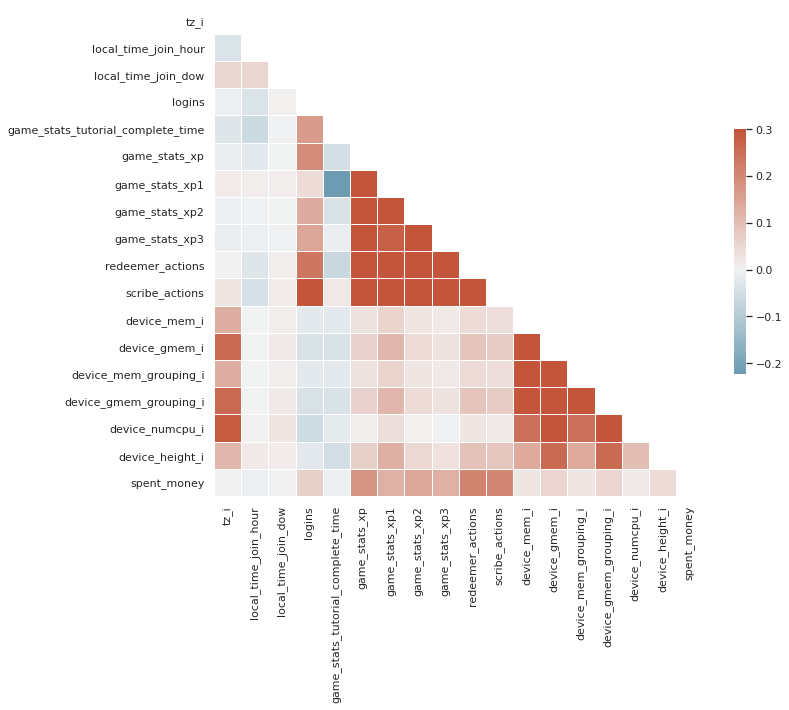

In [12]:
#most (98.25%) of the users in the remaining data do not spend any money in the game
#what factors might indicate a user will spend money? Plot a correlation matrix
sns.set_theme(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)

# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

# <a id='6'>6. Numeric Column Distribution</a>

Some numeric columns are skewed and the model can benefit from log transforming the data. A single column is treated below, but the following treatment should be investigated for all numeric columns.

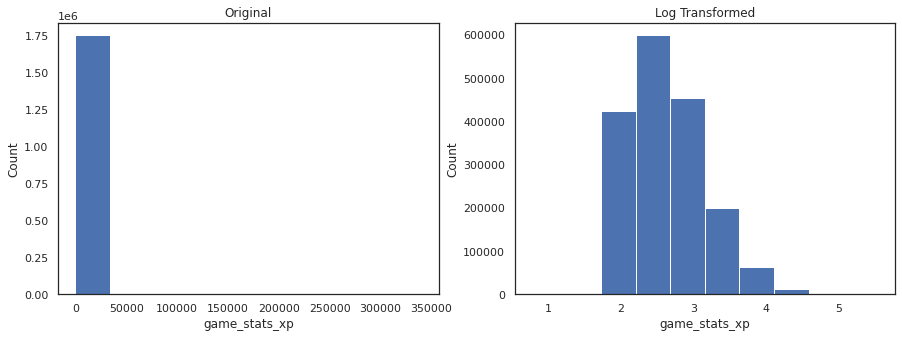

<Figure size 432x288 with 0 Axes>

In [13]:
for col in ['game_stats_xp']:
    fig, axs = plt.subplots(1, 2, figsize=(15,5))
    axs[0].hist(data[col])
    axs[0].set_xlabel(col)
    axs[0].set_ylabel('Count')
    axs[0].set_title('Original')
    
    data[col] = np.log10(data[col] + 1) #log transform the column to reduce skew in the numeric data
    plt.figure()
    axs[1].hist(data[col])
    axs[1].set_xlabel(col)
    axs[1].set_ylabel('Count')
    axs[1].set_title('Log Transformed')

# <a id='7'>7. Modelling Pipeline and Training</a>

A logistic regression model will be used for speed and simplicity. The model will output a predicted probability of the user spending some money in the game after finishing the tutorial. Because only a small fraction of users end up spending money, the classification threshold of the model will need to be tuned depending on the desired output (precision/recall tradeoff).

Depending on the type of data each column, we will either standardize, one-hot encode or target encode the data for training/testing. For target encoded columns, since so few users spend money, we must be sure each value has enough data points, otherwise there may not be any users that spend money for the value by random chance. Since about 2% of users spend money, this threshold will be set at 500 so that on average there will be around 10 users that spend money for the category (500*0.02=10).

In [14]:
numeric_cols = [ #numeric columns
        'logins', 'game_stats_xp', 'game_stats_xp1', 'game_stats_xp2', 'game_stats_xp3', 'redeemer_actions', 'scribe_actions', 
        'tz_i', 'local_time_join_hour', 'game_stats_tutorial_complete_time', 
        'device_mem_i', 'device_gmem_i', 'device_mem_grouping_i', 'device_gmem_grouping_i', 'device_numcpu_i', 'device_height_i'
               ] 

cat_cols = [ #categorical columns
           'lang_s', #language on users device
           'geo_s', #country level location of the user
           'region_s', #regional level location of the user
           'platform_s', #installation platform
           'device_mapped_s', #common name for device used
           'device_manufacturer_s', #device manufacturer
           'device_gpu_s', #chipset of the device
           'device_os_s', #operating system of the device
           'device_model_s' #model number of the device
          ]

original_num_values = [len(data[col].unique()) for col in cat_cols]
    
one_hot_cols = [ #these columns have <20 possible values so can be one-hot encoded
       'lang_s', #language on users device
       'region_s', #regional level location of the user
       'platform_s', #installation platform
]

high_card_cols = [col for col in cat_cols if col not in one_hot_cols] #these columns have >200 possible values so will be target encoded

#in the high cardinality columns, we will lump values with low counts (<500) into a single 'other' category
for col in high_card_cols:
    map_to_other = (data[col].value_counts()<500).to_dict() #dictionary that indicates which values should be mapped to 'other'
    data[col] = data[col].map(lambda x: 'other' if map_to_other[x] else x) #map the values to 'other'
    
new_num_values = [len(data[col].unique()) for col in cat_cols]

print('reduction in unique values for categotical columns')
for n, col in enumerate(cat_cols):
    print('Unique values in {}: {} --> {}'.format(col, original_num_values[n], new_num_values[n]))

reduction in unique values for categotical columns
Unique values in lang_s: 17 --> 17
Unique values in geo_s: 218 --> 89
Unique values in region_s: 5 --> 5
Unique values in platform_s: 2 --> 2
Unique values in device_mapped_s: 14098 --> 602
Unique values in device_manufacturer_s: 2047 --> 58
Unique values in device_gpu_s: 426 --> 65
Unique values in device_os_s: 56492 --> 450
Unique values in device_model_s: 14194 --> 610


In [15]:
#### create dataframes for modelling####
X = data.copy()
y = X.pop('spent_money')

#### pipeline ###
# Preprocessing for categorical data
numerical_transformer = Pipeline(steps=[ 
    ('num_standardizer', StandardScaler())])#standardization helps with linear models so certain features are not more heavily weighted simply because of their scale
one_hot_transformer = Pipeline(steps=[
    ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore')), 
    ])
target_transformer = Pipeline(steps=[
    ('target_encoder', TargetEncoder()), 
    ])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric_cols),
        ('one_hot', one_hot_transformer, one_hot_cols),
        ('target', target_transformer, high_card_cols)
    ])

model = LogisticRegression(solver='liblinear')

# Bundle preprocessing and modeling code in a pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

Below we train and test the data. Accuracy is not a good metric here since a model that predicted 0 100% of the time would still have >98% accuracy. We will use AUC instead.

In [16]:
#split training and test data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=41)

#fit on training data
pipeline.fit(X_train, y_train)

#predict
y_pred = pipeline.decision_function(X_train)
accuracy = roc_auc_score(y_train, y_pred)
print(f'AUC on training set: {accuracy:.4f}')
y_pred = pipeline.decision_function(X_test)
accuracy = roc_auc_score(y_test, y_pred)
print(f'\nAUC on testing set: {accuracy:.4f}')

/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


AUC on training set: 0.8506

AUC on testing set: 0.8489


Performance on the training and testing set is similar so it does not look like we are over-fitting.

# <a id='8'>8. Plot Prescision, Recall, and ROC</a>

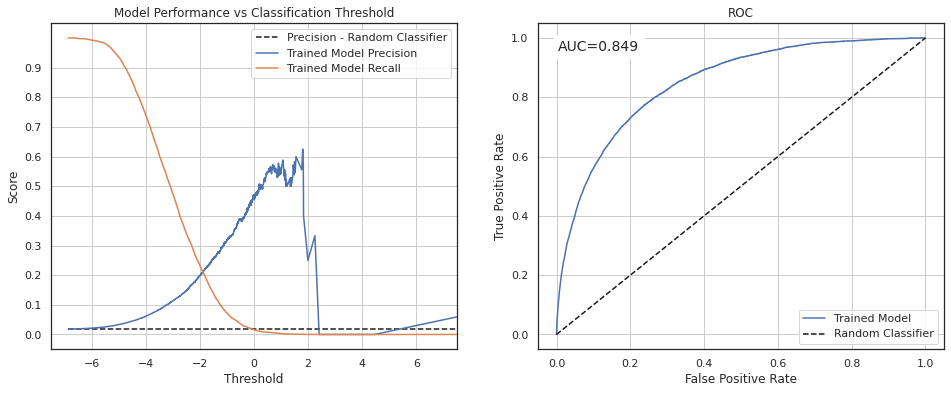

In [17]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc

probas_pred = pipeline.decision_function(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, probas_pred)
fpr, tpr, thresholds_roc = roc_curve(y_test, probas_pred)

pos_ratio = y_test.sum()/len(y_test)
AUC = auc(fpr, tpr)

import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2, figsize=(16,6))
#Plot precision and recall vs threshold
axs[0].set_title('Model Performance vs Classification Threshold')
axs[0].plot([thresholds[0],thresholds[-1]], [pos_ratio, pos_ratio], linestyle='--', color='k')
axs[0].plot(thresholds, precision[1:])
axs[0].plot(thresholds, recall[1:])
axs[0].set_xlabel('Threshold')
axs[0].set_ylabel('Score')
axs[0].set_yticks(np.arange(0, 1, step=0.1))
axs[0].set_xlim([-7.5, 7.5])
axs[0].legend(['Precision - Random Classifier', 'Trained Model Precision', 'Trained Model Recall'], loc='best')
axs[0].grid()
#Plot ROC
props = dict(boxstyle='square', facecolor='white')
axs[1].set_title('ROC')
axs[1].text(1.25, 0.95, 'AUC={:.3}'.format(AUC), transform=axs[0].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
axs[1].plot(fpr, tpr)
axs[1].plot([0,1], [0,1], linestyle='--', color='k')
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].legend(['Trained Model', 'Random Classifier'], loc='lower right')
axs[1].grid()
plt.show()

# <a id='9'>9. Plot Confusion Matrix for Chosen Threshold</a>

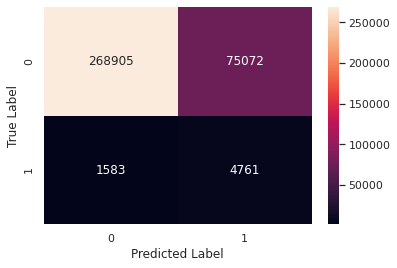

Final Recall (True Positivity): 75.0%
Final Precision: 5.96%
Final False Positivity: 21.8%


In [25]:
#1=will spend money, 0=will not spend money

thresh = -4.043
y_pred = [1 if ele>thresh else 0 for ele in probas_pred]

cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt="d")
ax.set(ylabel='True Label', xlabel='Predicted Label')
plt.show()

print('Final Recall (True Positivity): {:.3}%'.format(cm[1,1]/(cm[1,0]+cm[1,1])*100 ))
print('Final Precision: {:.3}%'.format(cm[1,1]/(cm[0,1]+cm[1,1])*100 ))
print('Final False Positivity: {:.3}%'.format(cm[0,1]/(cm[0,1]+cm[0,0])*100 ))

# <a id='10'>10. Conclusions</a>

By tuning the threshold of the linear model, it can find 75.0% of the test set users that will end up spending money in the game (recall). To do this, the model must include many users that will not spend money and only 5.96% of the positive guesses are correct (precision). We can offer a different price to the users the model has flagged with potential to spend money, but by doing so we will end up making the same offer to 21.8% of the users that will not spend money (false positivity).